In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import spacy
import nltk
from bs4 import BeautifulSoup
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from tqdm import tqdm
#Feature Engineering Models
from gensim.models import Word2Vec  ## We are importing python function for training a word2vec model.

# Preparing the dataset
from sklearn.model_selection import train_test_split   # split the dataset into training and testing set
from sklearn.model_selection import cross_val_score    # Perform cross validation 
from sklearn.model_selection import StratifiedKFold    # Stratify the data in each fold
from sklearn.model_selection import KFold 
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from sklearn.metrics import classification_report     # to get the performance measures
from sklearn.metrics import confusion_matrix          # To compute the false positives and false negatives
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score            # Accuracy measures

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load the data.

In [4]:
train =pd.read_csv('data/df_train_spell_hash.csv')
df = train[['target','comment_text']]

In [5]:
train.head()

,target,comment_text,comment_text_normalized
0,0.000000,"This is so cool. It's like, 'would you want yo...",cool like would want mother read really great ...
1,0.000000,Thank you!! This would make my life a lot less...,thank would make life lot less anxiety inducin...
2,0.000000,This is such an urgent design problem; kudos t...,urgent design problem judo take impressive
3,0.000000,Is this something I'll be able to install on m...,beth something able install site release
4,0.893617,haha you guys are a bunch of losers.,haha guy bunch loser


In [6]:
norm_text = train['comment_text_normalized'].tolist()
norm_text = [str(x) for x in norm_text]

In [7]:
norm_text[0]

'cool like would want mother read really great idea well'

In [8]:
doc = [x.split() for x in norm_text]
#doc

## Train Word2Vec model

In [9]:
#w2v_model=Word2Vec(sentences=doc, vector_size=300, window=7, epochs=20)  ## comment this out if loading an already saved model
w2v_model = Word2Vec.load("model/word2vec.model")  ## uncomment this out if loading an already saved model

In [10]:
#w2v_model.save("model/word2vec.model") ## comment this out if loading an already saved model

In [11]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    #print(doc)
    try:
        doc_vec = [word for word in doc if word in w2v_model.wv.index_to_key]
        #print(doc)
        return np.mean(w2v_model.wv[doc_vec], axis=0)
    except:
        pass
        #print(doc)

In [12]:
word_vecs = [document_vector(filtered_doc) for filtered_doc in tqdm(doc)]
#word_vecs

100%|██████████| 1804874/1804874 [46:13<00:00, 650.65it/s] 


In [13]:
len(word_vecs)

1804874

In [14]:
error_indices = [i for i in range(len(word_vecs)) if word_vecs[i] is None]
#error_indices

[7,
 297,
 413,
 2520,
 4089,
 9575,
 9813,
 11426,
 14033,
 20061,
 21532,
 22166,
 22802,
 23674,
 24825,
 25598,
 28526,
 29990,
 30526,
 31236,
 32704,
 33188,
 33313,
 37982,
 38068,
 38092,
 40757,
 40759,
 41826,
 42774,
 43160,
 43439,
 45121,
 45682,
 46828,
 46901,
 47436,
 49588,
 50170,
 50818,
 52534,
 53087,
 54014,
 54974,
 59302,
 59752,
 63348,
 65677,
 67729,
 70309,
 70839,
 71354,
 73539,
 73942,
 74930,
 76402,
 77086,
 77181,
 78986,
 79299,
 80330,
 80897,
 81609,
 82489,
 82601,
 84599,
 86829,
 87239,
 88947,
 89025,
 91389,
 92211,
 92654,
 93833,
 93856,
 95127,
 95889,
 97883,
 98591,
 99887,
 104256,
 105092,
 105237,
 105404,
 105904,
 107254,
 109674,
 110621,
 111540,
 112902,
 113417,
 113538,
 114804,
 115876,
 115954,
 118170,
 119652,
 121052,
 121268,
 123175,
 123340,
 123384,
 125845,
 126860,
 127690,
 128465,
 128468,
 129076,
 133036,
 134704,
 135733,
 135910,
 136036,
 138830,
 139123,
 139305,
 140073,
 141567,
 148421,
 150690,
 152074,
 15

## Drop records that threw an error

In [15]:
X_train_w2v = [i for i in tqdm(word_vecs) if i is not None]

100%|██████████| 1804874/1804874 [00:00<00:00, 2669459.80it/s]


In [16]:
X_train_w2v_df = pd.DataFrame(np.array(X_train_w2v))

In [17]:
X_train_w2v_df.shape

(1803664, 300)

In [18]:
y_train_w2v = train['target']
print(len(y_train_w2v))
y_train_w2v.drop(y_train_w2v.index[error_indices], inplace=True)
print(len(y_train_w2v))

1804874
1803664


In [ ]:
X_train_w2v_df.to_csv('data/X_train_w2v.csv', index=False)
y_train_w2v.to_csv('data/y_train_w2v.csv', index=False)

In [ ]:
X_train_w2v_df =pd.read_csv('data/X_train_w2v.csv')
y_train_w2v =pd.read_csv('data/y_train_w2v.csv')

## Split the data into 2 sets: 1) Training: 80%, 2) Testing: 20% and use Random Undersampling to balance the training set.

In [19]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [20]:
Y_train_w2v = np.where(y_train_w2v >=0.5,1.,0.)

In [21]:
Y_train_w2v

array([0., 0., 0., ..., 0., 1., 0.])

In [22]:
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v=train_test_split(X_train_w2v_df, Y_train_w2v, test_size=0.2)

In [23]:
X_over_w2v, y_over_w2v = undersample.fit_resample(X_train_w2v, Y_train_w2v)

In [24]:
len(y_over_w2v)

230524

In [25]:
np.unique(y_over_w2v, return_counts=True)

(array([0., 1.]), array([115262, 115262], dtype=int64))

## Use 5-fold Cross Validation and XGBoost to evaluate the training set

In [26]:
kfold = KFold(n_splits=5, random_state=7, shuffle=True)

In [ ]:
XGB=XGBClassifier()#verbosity=1)
results = cross_val_score(XGB, X_over_w2v, y_over_w2v, cv=kfold, scoring='precision', verbose=3)
print("Precision: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [ ]:
XGB=XGBClassifier()
results = cross_val_score(XGB, X_over_w2v, y_over_w2v, cv=kfold, scoring='recall', verbose=3)
print("Recall: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [ ]:
XGB=XGBClassifier()
results = cross_val_score(XGB, X_over_w2v, y_over_w2v, cv=kfold, scoring='f1', verbose=3)
print("F1: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [ ]:
XGB=XGBClassifier()
results = cross_val_score(XGB, X_over_w2v, y_over_w2v, cv=kfold, scoring='accuracy', verbose=3)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

In [ ]:
XGB=XGBClassifier(verbosity=1)

In [ ]:
XGB.fit(X_over_w2v, y_over_w2v)

In [ ]:
XGB.predict_proba(X_test_w2v)

In [ ]:
XGB.predict(X_test_w2v)

In [ ]:
confusion_matrix(Y_test_w2v, XGB.predict(X_test_w2v))

In [ ]:
print(classification_report(Y_test_w2v, XGB.predict(X_test_w2v)))

In [ ]:
XGB.score(X_test_w2v, Y_test_w2v)

In [ ]:
precision_score(Y_test_w2v, XGB.predict(X_test_w2v))

In [ ]:
recall_score(Y_test_w2v, XGB.predict(X_test_w2v))

In [ ]:
f1_score(Y_test_w2v, XGB.predict(X_test_w2v))

In [ ]:
accuracy_score(Y_test_w2v, XGB.predict(X_test_w2v))

In [ ]:
XGB.predict(X_test_w2v)

In [ ]:
del XGB

## Implementing MLP

### Holding out 10% as a validation set

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
nn_class2 = Sequential()
n_hidden = 64
n_input = X_over_w2v.shape[1]

# hidden layers
nn_class2.add(Dense(units=n_hidden, activation='relu',input_shape=(n_input,)))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))

# output layer
nn_class2.add(Dense(units=1, activation='sigmoid'))
nn_class2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_class2.summary()

In [ ]:
batch_size = 64
n_epochs = 150
history = nn_class2.fit(X_over_w2v, y_over_w2v, epochs=n_epochs, batch_size=batch_size, validation_split=0.1)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title("Accuracy vs. epochs", fontsize=15)
ax.set_xlabel("epoch number", fontsize=14)
ax.legend(fontsize=12)
#ax.set_ylim(0.0875,0.1)
ax.grid();

In [ ]:
fig.savefig('ValidationSet_LogLoss_Plot_Classification.pdf')

In [ ]:
nn_class2.evaluate(x=X_test_w2v, y=Y_test_w2v)

In [ ]:
predictions = nn_class2.predict(X_test_w2v)
predictions

### Holding out 10% as a validation set and implementing early stopping

In [ ]:
early_stoping = EarlyStopping(monitor='val_accuracy',
                min_delta=5,
                patience=20,
                verbose=1,
                mode='auto')

In [ ]:
nn_class2 = Sequential()
n_hidden = 64
n_input = X_over_w2v.shape[1]

# hidden layers
nn_class2.add(Dense(units=n_hidden, activation='relu',input_shape=(n_input,)))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))
nn_class2.add(Dense(units=n_hidden, activation='relu'))

# output layer
nn_class2.add(Dense(units=1, activation='sigmoid'))
nn_class2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_class2.summary()

In [ ]:
batch_size = 64
n_epochs = 150
history = nn_class2.fit(X_over_w2v, y_over_w2v,
epochs=n_epochs,
batch_size=batch_size,
validation_split=0.1,
callbacks=[early_stoping])

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title("Accuracy vs. epochs", fontsize=15)
ax.set_xlabel("epoch number", fontsize=14)
ax.legend(fontsize=12)
#ax.set_ylim(0.0875,0.1)
ax.grid();

In [ ]:
fig.savefig('2 - EarlyStopping_LogLoss_Plot_Classification.pdf')

In [ ]:
nn_class2.evaluate(x=X_test_w2v, y=Y_test_w2v)#, batch_size=2)

In [ ]:
predictions = nn_class2.predict(X_test_w2v)
predictions

### Holding out 10% as a validation set and implementing early stopping & dropout

In [40]:
nn_class_dropout = Sequential()
n_hidden = 64
dropout_rate = 0.3
n_input = X_over_w2v.shape[1]

## Dropout for input layer
nn_class_dropout.add(Dropout(rate=dropout_rate, input_shape=(n_input,)))

## Now adding four hidden layers + dropout for each of them
nn_class_dropout.add(Dense(units=n_hidden, activation='relu',input_shape=(n_input,)))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=n_hidden, activation='relu'))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=n_hidden, activation='relu'))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=n_hidden, activation='relu'))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=n_hidden, activation='relu'))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=n_hidden, activation='relu'))
nn_class_dropout.add(Dropout(rate=dropout_rate))
nn_class_dropout.add(Dense(units=1, activation='sigmoid'))

nn_class_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                19264     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [41]:
nn_class_dropout.compile(loss='binary_crossentropy', optimizer='adam',
metrics=['accuracy'])

In [42]:
batch_size = 64
n_epochs = 300
early_stoping = EarlyStopping(monitor='val_accuracy',
                min_delta=5,
                patience=40,
                verbose=1,
                mode='auto')

history = nn_class_dropout.fit(X_over_w2v, y_over_w2v,
                            epochs=n_epochs,
                            batch_size=batch_size,
                            validation_split=0.1,
                            callbacks=[early_stoping])

Epoch 1/300
3242/3242 [==============================] - 27s 8ms/step - loss: 0.5047 - accuracy: 0.7583 - val_loss: 0.3690 - val_accuracy: 0.8240
Epoch 2/300
3242/3242 [==============================] - 27s 8ms/step - loss: 0.4764 - accuracy: 0.7774 - val_loss: 0.3754 - val_accuracy: 0.8241
Epoch 3/300
3242/3242 [==============================] - 26s 8ms/step - loss: 0.4711 - accuracy: 0.7816 - val_loss: 0.3899 - val_accuracy: 0.8600
Epoch 4/300
3242/3242 [==============================] - 26s 8ms/step - loss: 0.4686 - accuracy: 0.7816 - val_loss: 0.3661 - val_accuracy: 0.8543
Epoch 5/300
3242/3242 [==============================] - 26s 8ms/step - loss: 0.4665 - accuracy: 0.7833 - val_loss: 0.3488 - val_accuracy: 0.8482
Epoch 6/300
3242/3242 [==============================] - 26s 8ms/step - loss: 0.4636 - accuracy: 0.7852 - val_loss: 0.3717 - val_accuracy: 0.8522
Epoch 7/300
3242/3242 [==============================] - 28s 9ms/step - loss: 0.4614 - accuracy: 0.7860 - val_loss: 0.3776 -

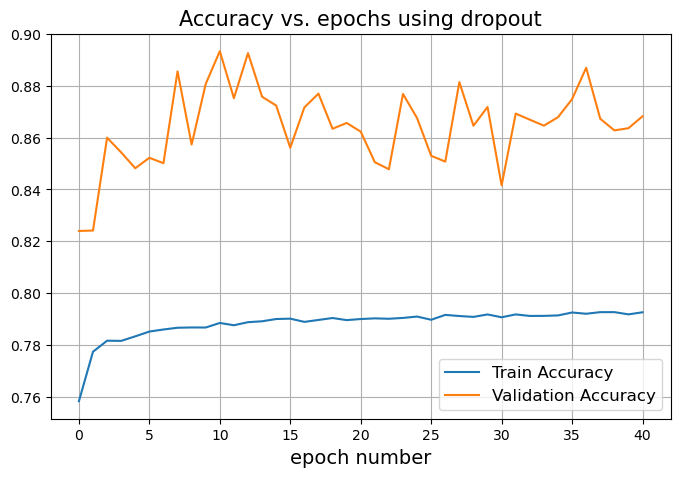

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title("Accuracy vs. epochs using dropout", fontsize=15)
ax.set_xlabel("epoch number", fontsize=14)
ax.legend(fontsize=12)
ax.grid();

In [44]:
fig.savefig('3. Dropout_LogLoss_Plot_Classification.pdf')

In [45]:
nn_class_dropout.evaluate(x=X_test_w2v, y=Y_test_w2v)

11273/11273 [==============================] - 47s 4ms/step - loss: 0.5223 - accuracy: 0.7533


[0.5223019123077393, 0.7533383369445801]

In [ ]:
predictions = nn_class_dropout.predict(X_test_w2v)
predictions

In [46]:
threshold = 0.5
nn_class_dropout_predictions = np.where(nn_class_dropout.predict(X_test_w2v) > threshold, 1,0)
nn_class_dropout_predictions

11273/11273 [==============================] - 25s 2ms/step


array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [60]:
threshold = 0.5
nn_class_dropout_predictions_train = np.where(nn_class_dropout.predict(X_train_w2v) >= threshold, 1,0)
nn_class_dropout_predictions_train

45092/45092 [==============================] - 104s 2ms/step


array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [61]:
confusion_matrix(Y_train_w2v, nn_class_dropout_predictions_train)

array([[987786, 339883],
       [ 14251, 101011]], dtype=int64)

In [62]:
print(classification_report(Y_train_w2v, nn_class_dropout_predictions_train))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85   1327669
         1.0       0.23      0.88      0.36    115262

    accuracy                           0.75   1442931
   macro avg       0.61      0.81      0.61   1442931
weighted avg       0.93      0.75      0.81   1442931



In [63]:
precision_score(Y_train_w2v, nn_class_dropout_predictions_train)

0.2291049549324781

In [64]:
recall_score(Y_train_w2v, nn_class_dropout_predictions_train)

0.876359945168399

In [65]:
f1_score(Y_train_w2v, nn_class_dropout_predictions_train)

0.3632470026395471

In [66]:
accuracy_score(Y_train_w2v, nn_class_dropout_predictions_train)

0.7545731569978051

In [54]:
confusion_matrix(Y_test_w2v, nn_class_dropout_predictions)

array([[246521,  85177],
       [  3802,  25233]], dtype=int64)

In [55]:
print(classification_report(Y_test_w2v, nn_class_dropout_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85    331698
         1.0       0.23      0.87      0.36     29035

    accuracy                           0.75    360733
   macro avg       0.61      0.81      0.60    360733
weighted avg       0.92      0.75      0.81    360733



In [56]:
precision_score(Y_test_w2v, nn_class_dropout_predictions)

0.22853908160492709

In [57]:
recall_score(Y_test_w2v, nn_class_dropout_predictions)

0.8690545892887894

In [58]:
f1_score(Y_test_w2v, nn_class_dropout_predictions)

0.3619061278640324

In [59]:
accuracy_score(Y_test_w2v, nn_class_dropout_predictions)

0.7533383416543538

## Evaluating dataset on new tweets pulled from Twitter

In [ ]:
tweets =pd.read_csv('data/tweets_normalized.csv')
#df = train[['target','comment_text']]

In [ ]:
tweets.head()

In [ ]:
norm_text = tweets['tweet_normalized'].tolist()
norm_text = [str(x) for x in norm_text]

In [ ]:
norm_text[0]

In [ ]:
doc = [x.split() for x in norm_text]
doc

In [ ]:
word_vecs = [document_vector(filtered_doc) for filtered_doc in tqdm(doc)]
word_vecs

In [ ]:
len(word_vecs)

In [ ]:
error_indices = [i for i in range(len(word_vecs)) if word_vecs[i] is None]
error_indices

In [ ]:
X_tweets_w2v = [i for i in tqdm(word_vecs) if i is not None]

In [ ]:
X_tweets_w2v_df = pd.DataFrame(np.array(X_tweets_w2v))

In [ ]:
X_tweets_w2v_df.shape

In [ ]:
X_tweets_w2v_df.to_csv('data/X_tweets_w2v.csv', index=False)

In [ ]:
X_tweets_w2v_df =pd.read_csv('data/X_tweets_w2v.csv')

In [ ]:
predictions = nn_reg_dropout.predict(pd.DataFrame(X_tweets_w2v))
predictions

In [ ]:
tweets['Prediction'] = predictions
tweets.to_csv('data/tweets_predicted.csv', index=False)

In [ ]:
print(X_test_w2v)

In [ ]:
print(pd.DataFrame(X_tweets_w2v))